In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import collections
import os
import shutil
import datetime
import keras_tuner as kt
import visualkeras

from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight


In [18]:
dataset_directory = "dataset_livrable_1/"

In [19]:
# def is_image(filename):
#     try:
#         with Image.open(filename) as img:
#             img.verify()
#         return True
#     except (UnidentifiedImageError, OSError):
#         return False

# def move_non_images(directory):
#     dump_directory = "dump"
#     os.makedirs(dump_directory, exist_ok = True)
    
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(folder, file)
#             if not is_image(file_path):
#                 print(f"Déplacement de {file_path} dans le dossier dump/")
#                 dest_path = os.path.join(dump_directory, file)
#                 try:
#                     shutil.move(file_path, dest_path)
#                 except:
#                     print("Erreur lors du déplacement")
                
# move_non_images(dataset_directory)

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
image_h = 128
image_w = 128
batch_s = 16

train_set, test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "both"
)

Found 41546 files belonging to 6 classes.
Using 33237 files for training.
Using 8309 files for validation.


In [21]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['Dataset Livrable 1 - Painting', 'Dataset Livrable 1 - Photo', 'Dataset Livrable 1 - Schematics', 'Dataset Livrable 1 - Sketch', 'Dataset Livrable 1 - Text', 'Dataset Livrable 2']


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
num_classes = len(class_names)

In [23]:
class ModelTest(Sequential):
    def __init__(self, activation = 'relu',*args, **kwargs):
        super(ModelTest, self).__init__(*args, **kwargs)
        self.add(layers.Rescaling(1./255))
        self.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = activation))
        self.add(layers.BatchNormalization())
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Dropout(0.1))
        self.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
        self.add(layers.BatchNormalization())
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Dropout(0.1))
        self.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
        self.add(layers.Flatten())
        self.add(layers.Dense(128, activation = activation))
        self.add(layers.Dropout(0.1))
        self.add(layers.Dense(num_classes, activation = 'softmax'))
        self.summary()
        self.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [26]:
class ModelTest2(Sequential):
    def __init__(self, activation = 'relu',*args, **kwargs):
        super(ModelTest2, self).__init__(*args, **kwargs)
        self.add(layers.Rescaling(1./255))
        self.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
        self.add(layers.ZeroPadding2D(padding = (1, 1)))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
        self.add(layers.ZeroPadding2D(padding = (1, 1)))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = activation))
        self.add(layers.Flatten())
        self.add(layers.Dense(64, activation = activation))
        self.add(layers.Dropout(0.1))
        self.add(layers.Dense(num_classes, activation = 'softmax'))
        self.summary()
        self.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [27]:
modeltest = ModelTest2()

Model: "model_test2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ ?                      │   0 (unbuilt) │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
callbacks = []
tensorboard_callback = TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1
)
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_model.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    verbose = 1
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    mode = 'max',
    restore_best_weights = True
)

# callbacks.append(early_stopping)
callbacks.append(tensorboard_callback)
callbacks.append(checkpoint_callback)

In [29]:
y_train = np.array([label.numpy() for _, label in train_set.unbatch()])
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
def train_model(model, train_set = train_set, test_set = test_set, weights = weights_dict, epochs = 10):

    history = model.fit(
        train_set,
        validation_data = test_set,
        epochs = epochs,
        callbacks = callbacks,
        class_weight = weights
    )
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    epochs_range = range(epochs) if epochs == 10 else range(len(accuracy))
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss")
    
    plt.show()

Epoch 1/30
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4277 - loss: 1.4975
Epoch 1: val_accuracy improved from -inf to 0.55675, saving model to checkpoints/best_model.keras
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 455s 216ms/step - accuracy: 0.4277 - loss: 1.4974 - val_accuracy: 0.5567 - val_loss: 1.0219
Epoch 2/30
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4354 - loss: 1.1292
Epoch 2: val_accuracy did not improve from 0.55675
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 390s 187ms/step - accuracy: 0.4354 - loss: 1.1292 - val_accuracy: 0.4146 - val_loss: 0.9426
Epoch 3/30
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5908 - loss: 0.7930
Epoch 3: val_accuracy improved from 0.55675 to 0.55819, saving model to checkpoints/best_model.keras
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 400s 192ms/step - accuracy: 0.5908 - loss: 0.7930 - val_accuracy: 0.5582 - val_loss: 0.7477
Epoch 4/30
2078/2078 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6041 - loss: 0.7778
Epoch 4: val_accuracy

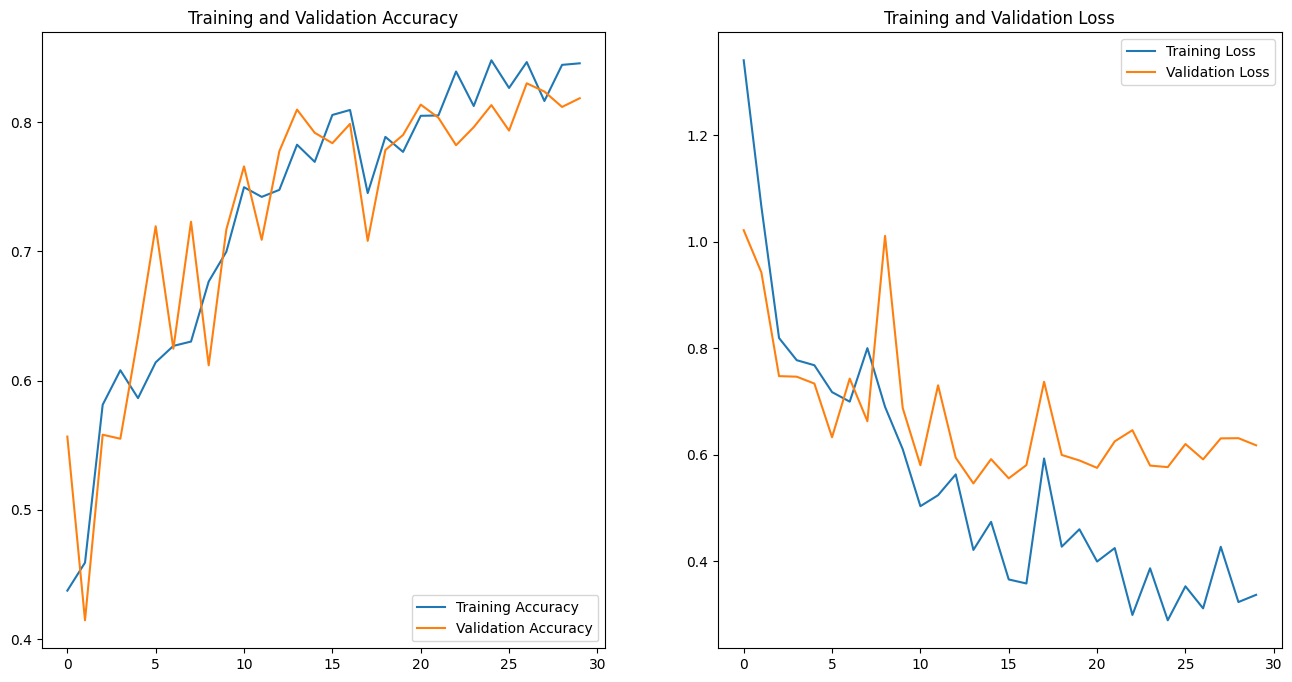

In [30]:
train_model(modeltest, epochs = 30)
modeltest.save('model.keras')

In [31]:
X_test = []
y_true = []

for images, labels in test_set:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)
def display_matrix(model, X_test = X_test, y_true = y_true, class_names = class_names):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()

260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step


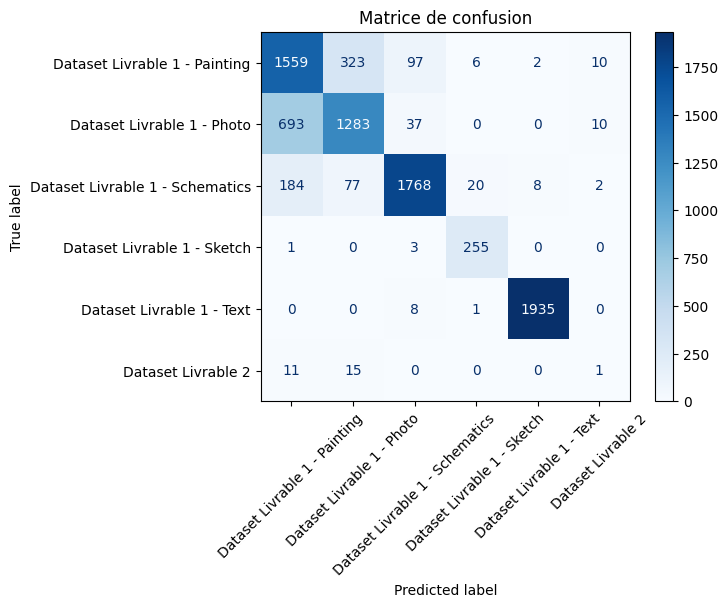

c:\Users\Lucien\Projects\data-science\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


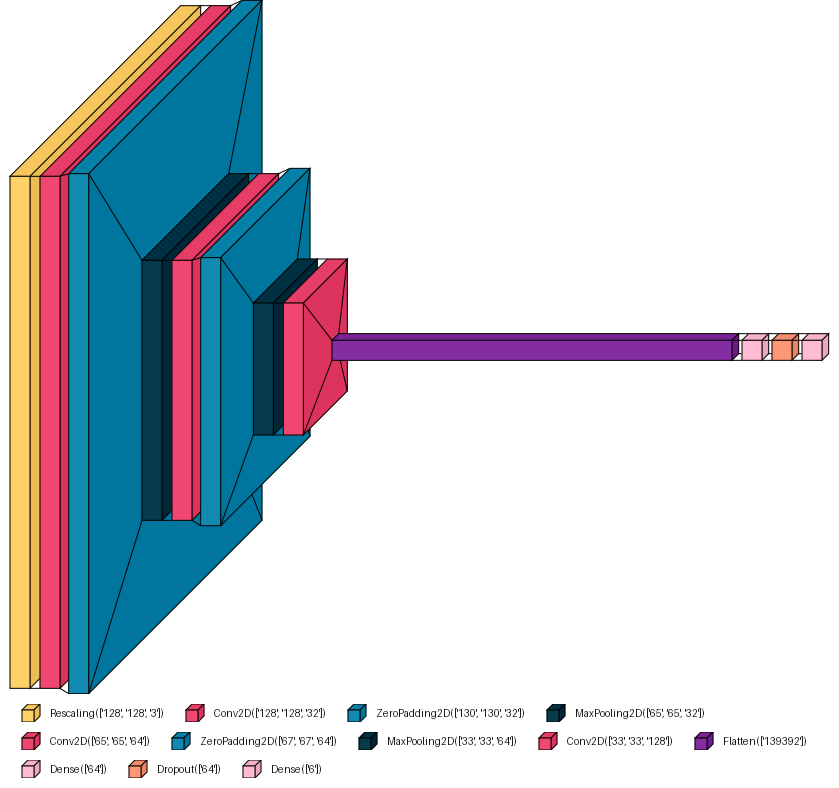

In [32]:
display_matrix(modeltest, X_test, y_true, class_names)
visualkeras.layered_view(
    modeltest,
    legend = True,
)
visualkeras.layered_view(
    modeltest,
    legend = True,
    show_dimension = True,
)

In [33]:
modeltest.summary()

Model: "model_test2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 130, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 67, 67, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 139392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     8,921,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,044,372 (103.17 MB)

 Trainable params: 9,014,790 (34.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,029,582 (68.78 MB)